#Multiple products and stochastic environment

Parameters :

*   T rounds
*   N number of types of products
*   P set of possible prices
*   B prduction capacity



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx # we will use it mostly for visualization
from scipy.optimize import linear_sum_assignment
from scipy.optimize import milp
from scipy import optimize
from scipy.sparse.csgraph import shortest_path

stochastic environment for our regret :

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def plot_weighted_matching_custom(matching, W, prd, prc, with_zeros=False):
    """
    matching : list of (i,j) pairs, indices of matched product i to price j
    W        : weight matrix (products x prices)
    prd      : list of product names (len = W.shape[0])
    prc      : list of price names/labels (len = W.shape[1])
    with_zeros : if True, show edges with weight 0 too
    """
    B = nx.Graph()

    # add product nodes (left side of bipartite)
    B.add_nodes_from(prd, bipartite=0)

    # add price nodes (right side of bipartite)
    B.add_nodes_from(prc, bipartite=1)

    # add edges with weights
    for i, j in matching:
        if with_zeros or W[i, j] > 0:
            B.add_edge(prd[i], prc[j])

    # bipartite layout: fix product side
    pos = nx.drawing.layout.bipartite_layout(B, prd)

    # draw graph
    nx.draw_networkx(B, pos=pos, width=2, with_labels=True, node_size=2000, node_color="lightblue")

    # draw edge labels with weights
    edge_labels = nx.get_edge_attributes(B, "weight")
    nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)

    plt.show()

In [3]:
def precomputed_realizations(products, prices, T, W):
  x = np.zeros((T,W.shape[0],W.shape[1]))
  for i, product in enumerate(products):
          for j, price in enumerate(prices):
              p = conversion_probability(i, price)  # compute conversion probability for this product-price
              x[:, i, j] = np.random.binomial(n=n_customers, p=p, size=T)

  return x

In [29]:
realization = precomputed_realizations(products, prices, T, W)

In [30]:
conversion_probability = lambda price_idx: max(0, 1 - 0.2*price_idx)

In [31]:
class BernoulliMatchingEnv:
    def __init__(self, W, T, costs, prices, n_customers, I, realization):
        self.W = W
        self.I = I
        self.n_customers = n_customers
        self.costs = np.array(costs)
        self.price_values = np.array(prices)
        # we can generate the realization in advance
        self.realizations = realization
        self.t = 0

    def print_Real(self):
        print(self.realizations)

    def round(self, matching):
        """
        matching: list of (product_index, price_index) tuples
        Reward is computed as profit = (price - cost[product]) * demand
        Demand is sampled from Bernoulli conversion probabilities.
        If price == -1, demand and reward are set to 0.
        """
        products, prices = list(zip(*matching))
        products = np.array(products)
        prices   = np.array(prices)

        # Initialize demand and reward as zeros
        d_t = np.zeros(len(products), dtype=int)
        r_t = np.zeros(len(products), dtype=float)

        # Mask for valid prices
        valid_mask = prices != -1

        if np.any(valid_mask):
            # Conversion probabilities for valid entries
            d_valid = self.realizations[self.t][products[valid_mask], prices[valid_mask]]

            # Compute profits: (price_value - cost) * demand
            r_valid = np.maximum(
                (self.price_values[prices[valid_mask]] - self.costs[products[valid_mask]]) * d_valid,
                0
            )

            # Assign back to full arrays
            d_t[valid_mask] = d_valid
            r_t[valid_mask] = r_valid

        self.t += 1
        return d_t, r_t

In [7]:
import numpy as np
from scipy import optimize


class CombinatorialUCB:
    def __init__(self, N, P, B, T, epsilon=0.05):
        """
        N: number of products
        P: number of prices
        B: shared capacity
        T: time horizon
        epsilon: exploration probability for epsilon-greedy
        """
        self.N = N
        self.P = P
        self.B = B
        self.T = T
        self.epsilon = epsilon

        self.counts = np.zeros((N, P))  # times each arm is chosen
        self.means = np.zeros((N, P))   # estimated mean rewards
        self.avg_c = np.zeros((N, P))   # estimated consumption
        self.t = 0

    def pull_arm(self):
        """
        Choose prices for each product.
        Returns:
            prices: list of chosen price indices per product (-1 = not sold)
        """
        prices = []

        # If inventory exhausted, sell nothing
        if self.B < 1:
            return [-1] * self.N

        # Initial exploration (each product at each price once)
        if self.t < self.N * self.P:
            i = self.t // self.P           # product index
            price_idx = self.t % self.P    # price index
            prices = [-1] * self.N         # don't sell other products
            prices[i] = price_idx
            return prices

        # UCB estimates
        exploration_bonus = np.sqrt(2 * np.log(self.t + 1) / (self.counts + 1e-6))
        f_ucbs = self.means + exploration_bonus
        c_lcbs = np.maximum(self.avg_c - exploration_bonus, 0)  # clip at 0

        # Solve LP to get probabilities
        gamma = self.compute_opt(f_ucbs, c_lcbs)

        # ε-greedy exploration
        if np.random.rand() < self.epsilon:
            return list(np.random.randint(self.P, size=self.N))

        # Sample a price per product using gamma
        for i in range(self.N):
            probs = gamma[i]
            if probs.sum() > 0:
                probs = probs / probs.sum()
                price_idx = np.random.choice(self.P, p=probs)
                prices.append(price_idx)
            else:
                prices.append(-1)  # skip if LP gave zero probability

        return prices

    def compute_opt(self, f_ucbs, c_lcbs):
        """
        f_ucbs: N x P array of UCB estimates of expected rewards
        c_lcbs: N x P array of LCB estimates of expected consumption
        Returns:
            gamma: N x P array of probabilities over prices per product
        """
        rho = max(self.B / max(1, self.T - self.t), 0)

        # Objective function: maximize reward (minimize -reward)
        c = -f_ucbs.flatten()

        # Inequality constraint: expected cost <= rho
        A_ub = [c_lcbs.flatten()]
        b_ub = [rho]

        # Equality constraints: each product must assign probabilities across prices
        A_eq = []
        b_eq = []
        for i in range(self.N):
            row = np.zeros(self.N * self.P)
            row[i * self.P:(i + 1) * self.P] = 1
            A_eq.append(row)
            b_eq.append(1.0)

        # Bounds: x >= 0
        bounds = (0, None)

        # Solve LP
        res = optimize.linprog(
            c,
            A_ub=A_ub,
            b_ub=b_ub,
            A_eq=A_eq,
            b_eq=b_eq,
            bounds=bounds,
        )

        if res.success:
            gamma = res.x.reshape(self.N, self.P)
        else:
            gamma = np.ones((self.N, self.P)) / self.P  # fallback: uniform

        return gamma

    def update(self, prices, demand, rewards):
        """
        prices: list of chosen price indices per product (-1 if not sold)
        demand: list of units sold per product
        rewards: observed per-product reward
        """
        self.t += 1

        for i in range(self.N):
            p = prices[i]
            if p == -1:
                continue  # product not sold, skip

            units_sold = demand[i]

            # Update inventory
            self.B -= units_sold
            if self.B < 0:
                self.B = 0

            # Update reward estimates
            self.counts[i, p] += 1
            n = self.counts[i, p]
            self.means[i, p] += (rewards[i] - self.means[i, p]) / n
            self.avg_c[i, p] += (units_sold - self.avg_c[i, p]) / n


In [13]:
num_products = 5
num_prices = 6
n_customers = 30
T = 500
I = 10000

# List of products
products = ["Laptop", "Mouse", "Keyboard", "Smartphone", "Headphones"]
costs = [800.00, 10.50, 20.00, 200.00, 50.00]
prices = [ 50, 150, 500, 800, 1000, 1200]

# profit matrix
W = np.zeros((num_products, num_prices))
for i, cost in enumerate(costs):
    for j, price in enumerate(prices):
        profit = price - cost
        if W[i, j] < profit:
           W[i, j] = profit if profit > 0 else -999

In [49]:
alpha = {
    "Laptop": 1.6,      # r ≈ 1280
    "Mouse":  6.0,      # r ≈ 63
    "Keyboard": 8.0,    # r ≈ 160
    "Smartphone": 4.2,     # r ≈ 440
    "Headphones": 5.0   # r ≈ 150
}

# Build reservation prices r_i
r = np.array([alpha[name] * c for name, c in zip(products, costs)], dtype=float)
print(r)

p_max = 0.95  # cap max conversion

def conversion_probability(i, price):
    c_i, r_i = costs[i], r[i]
    # Handle degenerate case if r_i <= c_i (force a tiny spread)
    if r_i <= c_i:
        r_i = c_i + 1e-6
    if price <= c_i:
        return 0.95
    if price >= r_i:
        return 0.0
    # Linear decay from c_i (p_max) to r_i (0)
    return p_max * (r_i - price) / (r_i - c_i)

[1280.   63.  160.  840.  250.]


In [46]:
import numpy as np

def realized_clairvoyant(realizations, prices, costs, n_customers, B, T):
    """
    realizations : array [T, N, P] with conversion probabilities
    prices       : list of price values (len = P)
    costs        : list of costs (len = N)
    n_customers  : customers per round
    B            : total inventory
    T            : horizon
    Returns:
        total_reward : total profit over horizon
        chosen_pairs : list of lists of (product_index, price_index) per round
    """
    N, P = len(costs), len(prices)
    total_reward, B_left = 0, B
    chosen_pairs = []

    for t in range(T):
        if B_left <= 0:
            break

        round_pairs = []
        best_profit_per_product = []

        # for each product, pick the price with highest profit
        for i in range(N):
            best_j = None
            best_profit = -np.inf
            for j in range(P):
                demand = realizations[t][i, j] * n_customers
                unit_profit = prices[j] - costs[i]
                profit = unit_profit * demand
                if profit > best_profit:
                    best_profit = profit
                    best_j = j
            if best_profit > 0:
                best_profit_per_product.append((best_profit, i, best_j))

        # sort products by profit descending
        best_profit_per_product.sort(reverse=True, key=lambda x: x[0])

        round_reward = 0
        for profit, i, j in best_profit_per_product:
            if B_left <= 0:
                break
            round_reward += profit
            B_left -= 1  # we just assume 1 unit counts towards inventory
            round_pairs.append((i, j))

        total_reward += round_reward
        chosen_pairs.append(round_pairs)

    return total_reward


In [47]:
clairvoyant_total_reward = realized_clairvoyant(realization, prices, costs, n_customers, I, T)
print(clairvoyant_total_reward)

155230035.0


Round  1
  Agent prices:  [0, -1, -1, -1, -1]
  Demand:        [28  0  0  0  0]
  Remaining B:   10000
  Rewards:       [0. 0. 0. 0. 0.]
  Cumulative regret: 310460.07

Round  2
  Agent prices:  [1, -1, -1, -1, -1]
  Demand:        [29  0  0  0  0]
  Remaining B:   9972
  Rewards:       [0. 0. 0. 0. 0.]
  Cumulative regret: 620920.14

Round  3
  Agent prices:  [2, -1, -1, -1, -1]
  Demand:        [30  0  0  0  0]
  Remaining B:   9943
  Rewards:       [0. 0. 0. 0. 0.]
  Cumulative regret: 931380.21

Round  4
  Agent prices:  [3, -1, -1, -1, -1]
  Demand:        [26  0  0  0  0]
  Remaining B:   9913
  Rewards:       [0. 0. 0. 0. 0.]
  Cumulative regret: 1241840.28

Round  5
  Agent prices:  [4, -1, -1, -1, -1]
  Demand:        [15  0  0  0  0]
  Remaining B:   9887
  Rewards:       [3000.    0.    0.    0.    0.]
  Cumulative regret: 1549300.35

Round  6
  Agent prices:  [5, -1, -1, -1, -1]
  Demand:        [5 0 0 0 0]
  Remaining B:   9872
  Rewards:       [2000.    0.    0.    0.    

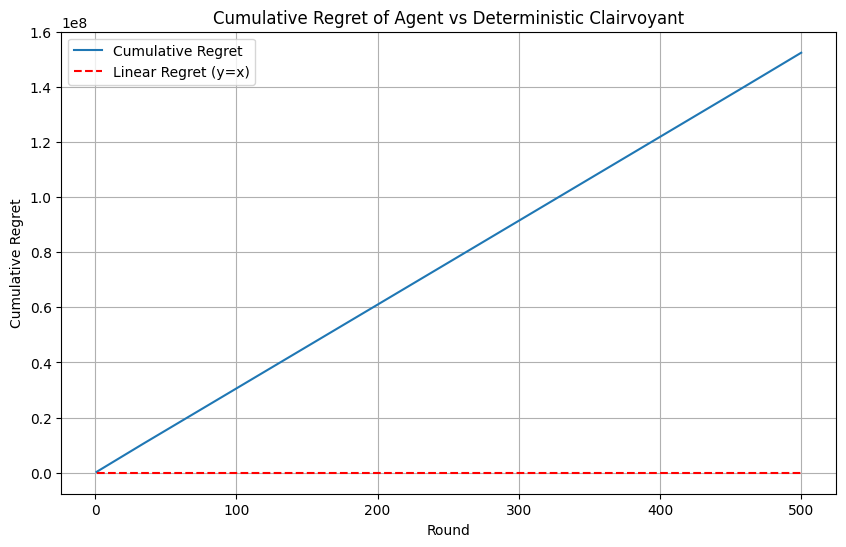

In [61]:
# deterministic clairvoyant
best_pairs = np.zeros((num_products, 2))

for i in range(num_products):
    best_reward = 0
    for j in range(num_prices):
        expected = W[i, j] * conversion_probability(i,prices[j]) * n_customers

        if expected > best_reward:
            # found a strictly better reward → reset list
            best_reward = expected
            best_pairs[i, 0] = i
            best_pairs[i, 1] = j

clairvoyant_matching = list(best_pairs)


W = np.random.rand(num_products, num_prices)

np.random.seed(42)

env = BernoulliMatchingEnv(W, T, costs, prices, n_customers, I, realization)
#agent = UCBMatchingAgent(len(products) , len(prices),T, I)
agent = CombinatorialUCB(len(products) , len(prices), I, T)

agent_rewards = np.array([])
agent_superarms = []

history_agent_rewards = []
cumulative_regret = []

last = []
l_agent = 0

for t in range(T):
    prices_agent = agent.pull_arm()

    # Construct the matching list in the correct format (product_index, price_index)
    matching_for_env = []
    for product_idx, price_idx in enumerate(prices_agent):
        matching_for_env.append((product_idx, price_idx))

    demand_agent, rewards_agent = env.round(matching_for_env)
    print(f"Round {t+1:2d}")
    print(f"  Agent prices:  {prices_agent}")
    print(f"  Demand:        {demand_agent}")
    print(f"  Remaining B:   {agent.B}")
    print(f"  Rewards:       {rewards_agent}")
    agent.update(prices_agent, demand_agent, rewards_agent)

    agent_rewards = np.append(agent_rewards, np.sum(rewards_agent)) # Sum the rewards for the round
    agent_superarms.append(prices_agent)

    history_agent_rewards.append(rewards_agent.sum()) # Sum the rewards for the round

    # compute cumulative regret
    total_agent_reward = sum(history_agent_rewards)
    regret_t = clairvoyant_total_reward * (t+1)/T - total_agent_reward
    cumulative_regret.append(regret_t)

    print(f"  Cumulative regret: {regret_t:.2f}\n")
    if t == 0 or rewards_agent.sum() > l_agent :
      last = prices_agent
      l_agent = rewards_agent.sum()

#cumulative_regret = np.cumsum(clairvoyant_total_reward-agent_rewards)

# Final comparison
total_agent_reward = sum(history_agent_rewards)
total_regret = clairvoyant_total_reward - total_agent_reward

print("=== Final Results ===")
print(f"Total agent reward:       {total_agent_reward:.2f}")
print(f"Deterministic clairvoyant reward: {clairvoyant_total_reward:.2f}")
print(f"Total regret:             {total_regret:.2f}")
plt.figure(figsize=(10,6))
plt.plot(range(1, T+1), cumulative_regret, label='Cumulative Regret')
plt.plot(range(1, T+1), range(1, T+1), 'r--', label='Linear Regret (y=x)')  # linear reference
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret of Agent vs Deterministic Clairvoyant")
plt.grid(True)
plt.legend()
plt.show()

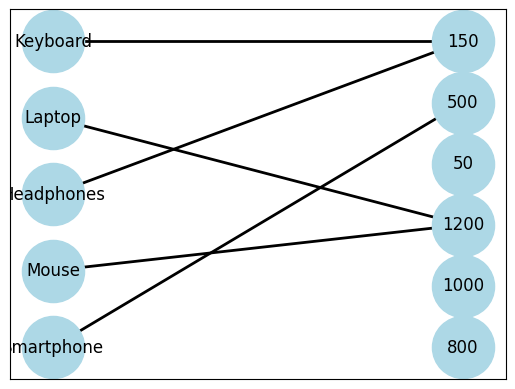

In [59]:
b_pairs = np.zeros((num_products, 2))

for i in range(num_products):
   b_pairs[i,0] = i
   b_pairs[i,1] = last[i]

alg_result = list(b_pairs)
alg_res_int = [(int(i[0]), int(i[1])) for i in alg_result]

plot_weighted_matching_custom(alg_res_int, W, products, prices)